In [2]:
# imports of necessary packages
from domains.Inventory import Inventory
from exploration.DecayingEpsilon import DecayingEpsilon
from agents.DeepAgent import DeepAgent
from training.Trainer import Trainer

import random
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.regularizers import l2

In [3]:
# set up the domain
domain = Inventory()

# use default encoding for the states
encoding = domain.default_encoding

In [4]:
# let's import the pre-trained networks to use as the experts
model_good = keras.models.load_model('C:\\Users\\Michael\\Dropbox'
                                     '\\rl\\notebooks\\inventory_model_128_by_2.h5')

In [5]:
# now we will define the shaping functions from these networks
def good_shape(state):
    return np.amax(model_good.predict(encoding(state))[0])

def bad_shape(state):
    return -good_shape(state)

def zero_shape(state):
    return 0.0

def random_shape(state):
    return 10.0 * random.random()

In [6]:
# set up the neural network as the function approximator
model = Sequential()
regularizer = l2(1e-6)
model.add(Dense(64,
                input_dim=domain.state_dim(),
                activation='relu',
                kernel_regularizer=regularizer))
model.add(Dense(64,
                activation='relu',
                kernel_regularizer=regularizer))
model.add(Dense(domain.action_count(),
                activation='linear',
                kernel_regularizer=regularizer))
model.compile(optimizer=Adam(lr=0.0005), loss='mse')
print(model.summary())

# set up the exploration schedule for the greedy epsilon policy
eps_schedule = DecayingEpsilon(0.5, 0.01, 0.98)

# set up the learning agent
agent = DeepAgent(domain.state_dim(), domain.action_count(), 0.975)
agent.setup_nn(batch_size=32, 
               epochs_per_batch=1,
               memory_size=32000, 
               network=model)

# finally create the training algorithm
training = Trainer(domain, agent, encoding)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 42)                2730      
Total params: 7,402
Trainable params: 7,402
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
# we start by training for 10 trials on all the experts and sarsa
experts = [zero_shape, good_shape, bad_shape, random_shape]
data_sarsa = training.run_many(trials=10, epochs=125, horizon=100, 
                               exploration=eps_schedule, experts=experts,
                               method='sarsa', 
                               replay_online_every=1, replays_offline=0,
                               measure=None)

Trial 0 complete.


Trial 1 complete.


Trial 2 complete.


Trial 3 complete.


Trial 4 complete.


Trial 5 complete.


Trial 6 complete.


Trial 7 complete.


Trial 8 complete.


Trial 9 complete.


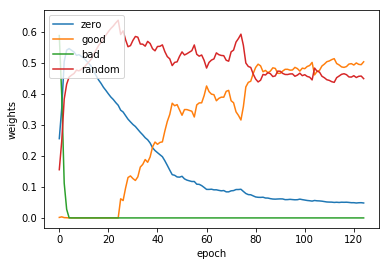

In [8]:
# now let's plot the bayesian weights
plt.xlabel('epoch')
plt.ylabel('weights')
legend_labels = ['zero', 'good', 'bad', 'random']
for i, series in enumerate(data_sarsa['weights']):
    plt.plot(series, label=legend_labels[i])
plt.legend(loc='upper left')
plt.show()

In [9]:
# as expected, the model will assign more weight to the good expert
# fortunately it is assigning no weight to the bad expert, but it prefers the 
# random expert at the beginning. 
# it may be because the rewards are noisy during training
# but could also be due to numerical or other errors
# will need to investigate the reason for this

In [11]:
# let's compare this to no shaping
data_sarsa_bench = training.run_many(trials=10, epochs=125, horizon=100, 
                                     exploration=eps_schedule, experts=[zero_shape],
                                     method='sarsa', 
                                     replay_online_every=1, replays_offline=0,
                                     measure=None)

Trial 0 complete.


Trial 1 complete.


Trial 2 complete.


Trial 3 complete.


Trial 4 complete.


Trial 5 complete.


Trial 6 complete.


Trial 7 complete.


Trial 8 complete.


Trial 9 complete.


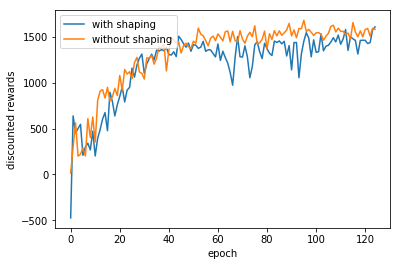

In [12]:
# let's plot the progress
plt.xlabel('epoch')
plt.ylabel('discounted rewards')
plt.plot(data_sarsa['rewards'], label='with shaping')
plt.plot(data_sarsa_bench['rewards'], label='without shaping')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Interestingly, for the current setup, reward shaping has not helped convergence.
# This could either be because the domain is already fairly simple, or because
# the architecture used as one of the experts was not trained correctly.
# I think the reward needs to also be computed off policy, although 
# epsilon is decaying quite rapidly here.
# More work will need to be done to correct this in the near future.